In [193]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    !pip install pandas numpy matplotlib
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

# ==========================================
# 1. THE "PLANT" (Simulation Environment)
# ==========================================

In [194]:
class SmartHomeEnv:
    def __init__(self, battery_capacity=10.0, max_power=5.0, seed=42):
        self.battery_capacity = battery_capacity # kWh
        self.max_power = max_power # kW
        self.soc = 0.0 # Initial State of Charge (kWh)
        self.time_step = 0

        # Set a fixed seed for reproducibility
        np.random.seed(seed)

        # Internal Data Generation (The "Real World")
        self.data = self._generate_scenario_data(hours=72)

    def _generate_scenario_data(self, hours):
        t = np.arange(hours)
        # Solar: Peak at noon + random clouds
        solar = np.maximum(0, 5 * np.sin(2 * np.pi * (t - 6) / 24))
        solar = np.maximum(0, solar - 0.2 * np.random.weibull(0.5, size=hours))

        # Load: Morning/Evening peaks
        load = 2 + np.cos(4 * np.pi * (t - 18) / 24) + \
                0.8 * np.cos(2 * np.pi * (t - 14) / 24)
        load = np.maximum(0.5, load)
        # Price: High in evening
        price = 0.20 + 0.10 * np.cos(2 * np.pi * (t - 18) / 24)

        return pd.DataFrame({'solar': solar, 'load': load, 'price': price})

    def reset(self):
        self.soc = 0.0
        self.time_step = 0
        return self.data.iloc[0]

    def step(self, action_kw):
        """
        Executes one time step.
        Args:
            action_kw (float): Desired battery power (+ Charge, - Discharge)
        Returns:
            observation (Series): The NEXT state (load, solar, price)
            reward (float): The cost incurred this step
            done (bool): Is simulation over?
            info (dict): Debug info
        """
        current_data = self.data.iloc[self.time_step]

        # --- 1. Apply Physics Constraints (The "Real" Battery) ---
        # A. Power Limits
        power = np.clip(action_kw, -self.max_power, self.max_power)

        # B. Capacity Limits
        if power > 0: # Charging
            max_charge = self.battery_capacity - self.soc
            power = min(power, max_charge)
        else: # Discharging
            max_discharge = self.soc
            power = max(power, -max_discharge) # (power is negative)

        # --- 2. Update State ---
        self.soc += power # Simple energy bucket model (1 hour timestep)

        # --- 3. Calculate Cost ---
        # Grid Balance: Load + Charge = Solar + Discharge + Grid
        # Grid = (Load - Solar) + Power
        net_load = current_data['load'] - current_data['solar']
        grid_kw = net_load + power

        cost = grid_kw * current_data['price']

        # --- 4. Prepare Next Step ---
        self.time_step += 1
        done = self.time_step >= len(self.data)

        next_obs = None
        if not done:
            next_obs = self.data.iloc[self.time_step]

        info = {
            'soc': self.soc,
            'grid_kw': grid_kw,
            'battery_action_actual': power,
            'load': current_data['load'],
            'solar': current_data['solar'],
            'price': current_data['price']
        }

        return next_obs, cost, done, info

    def get_forecast(self, horizon=24):
        """Returns the data for the next N hours (for MPC)"""
        start = self.time_step
        end = min(start + horizon, len(self.data))
        return self.data.iloc[start:end]

# ==========================================
# 2. THE CONTROLLERS
# ==========================================

In [195]:
class Controller:
    """Base controller: stores battery capacity and max power values and defines interface."""
    def __init__(self, env):
        self.bat_cap = env.battery_capacity
        self.max_p = env.max_power

    def get_action(self, observation):
        raise NotImplementedError

In [196]:
class RuleBasedController(Controller):
    """Store excess solar; discharge to meet deficits."""

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        if net_load < 0:
            return self.max_p
        else:
            return -self.max_p

In [197]:
class CostOptimizedRuleBasedController(Controller):
    """Charge from surplus solar; discharge when price is high; otherwise hold."""
    def __init__(self, env, price_threshold=0.25):
        super().__init__(env)
        self.price_threshold = price_threshold

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        current_price = observation['price']
        if net_load < 0:
            return self.max_p
        else:
            if current_price > self.price_threshold:
                return -self.max_p
            else:
                return 0.0

In [198]:
class SOCAwareRuleBasedController(Controller):
    """SoC-aware controller: respects SoC buffers when charging/discharging and uses price threshold."""
    def __init__(self, env, price_threshold=0.25):
        super().__init__(env)
        self.price_threshold = price_threshold

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        current_price = observation['price']
        charge_buffer = self.max_p * 0.1
        discharge_buffer = self.max_p * 0.1
        if net_load < 0:
            if current_soc < self.bat_cap - charge_buffer:
                return self.max_p
            else:
                return 0.0
        else:
            if current_price > self.price_threshold:
                if current_soc > discharge_buffer:
                    return -self.max_p
                else:
                    return 0.0
            else:
                return 0.0

In [199]:
class PVOptimalController(Controller):
    """Prioritize PV: charge on surplus; discharge if SoC above minimum; optionally grid-charge to safety buffer."""
    def __init__(self, env, min_soc_percent=0.1, safety_buffer_percent=0.1):
        super().__init__(env)
        self.min_soc_kwh = self.bat_cap * min_soc_percent
        self.safety_buffer_kwh = self.bat_cap * safety_buffer_percent

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        action = 0.0
        if net_load < 0:
            action = self.max_p
        else:
            if current_soc > self.min_soc_kwh:
                action = -self.max_p
            else:
                if current_soc < self.safety_buffer_kwh:
                    charge_needed = self.safety_buffer_kwh - current_soc
                    action = min(self.max_p, charge_needed)
        return action

In [200]:
class RandomController(Controller):
    """Random actions within allowed power limits."""
    def get_action(self, observation, _):
        return np.random.uniform(-self.max_p, self.max_p)

In [201]:
class SoCSolarDemandController(Controller):
    """Decisions based only on SoC, solar, and demand: charge on surplus if room, discharge on deficit if above min SoC."""
    def __init__(self, env, min_soc_percent=0.05, max_soc_percent=0.95):
        super().__init__(env)
        self.min_soc_kwh = self.bat_cap * min_soc_percent
        self.max_soc_kwh = self.bat_cap * max_soc_percent

    def get_action(self, observation, current_soc):
        net_load = observation['load'] - observation['solar']
        if net_load < 0 and current_soc < self.max_soc_kwh:
            return self.max_p
        if net_load > 0 and current_soc > self.min_soc_kwh:
            return -self.max_p
        return 0.0

# ==========================================
# 3. MAIN LOOP (The "Gym" Loop)
# ==========================================

In [202]:
def run_experiment(Controller):
    # Setup
    env = SmartHomeEnv()
    agent = Controller(env)
   # agent = CostOptimizedRuleBasedController(env)
   # agent = SOCAwareRuleBasedController(env)
    # History Storage
    results = []

    # Start
    obs = env.reset()
    done = False

    print("Starting Simulation...")

    while not done:
        # 1. Agent decides
        # Note: RuleBased needs current SOC to be perfect, but here we
        # just ask for MAX and let physics clip it.
        action_requested = agent.get_action(obs, env.soc)

        # 2. Environment reacts
        next_obs, cost, done, info = env.step(action_requested)

        # 3. Store Data
        info['action_requested'] = action_requested # Log the requested action
        results.append(info)

        # 4. Advance
        obs = next_obs

    # Process Results
    df_res = pd.DataFrame(results)
    return df_res

# ==========================================
# 4. VISUALIZATION
# ==========================================

In [203]:
def plot_controller_performance(df, controller_name, total_cost):
    print(f"Total Cost for {controller_name}: €{total_cost:.2f}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Ax1: Physics
    ax1.set_title(f"{controller_name}: Power Flows")
    ax1.plot(df['load'], 'k--', label='Load', alpha=0.5)
    ax1.plot(df['solar'], 'orange', label='Solar', alpha=0.5)
    ax1.bar(df.index, df['battery_action_actual'], color='green', alpha=0.3, label='Battery Flow')
    ax1.legend()
    ax1.set_ylabel("kW")

    # Ax2: Battery State
    ax2.set_title(f"{controller_name}: Battery State of Charge")
    ax2.plot(df['soc'], 'g-', linewidth=2)
    ax2.set_ylabel("kWh")
    ax2.set_xlabel("Hour")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# 5. COMPARISON
# ==========================================

In [215]:
list(all_results)[0]

'RandomController'

Starting Simulation...
Starting Simulation...


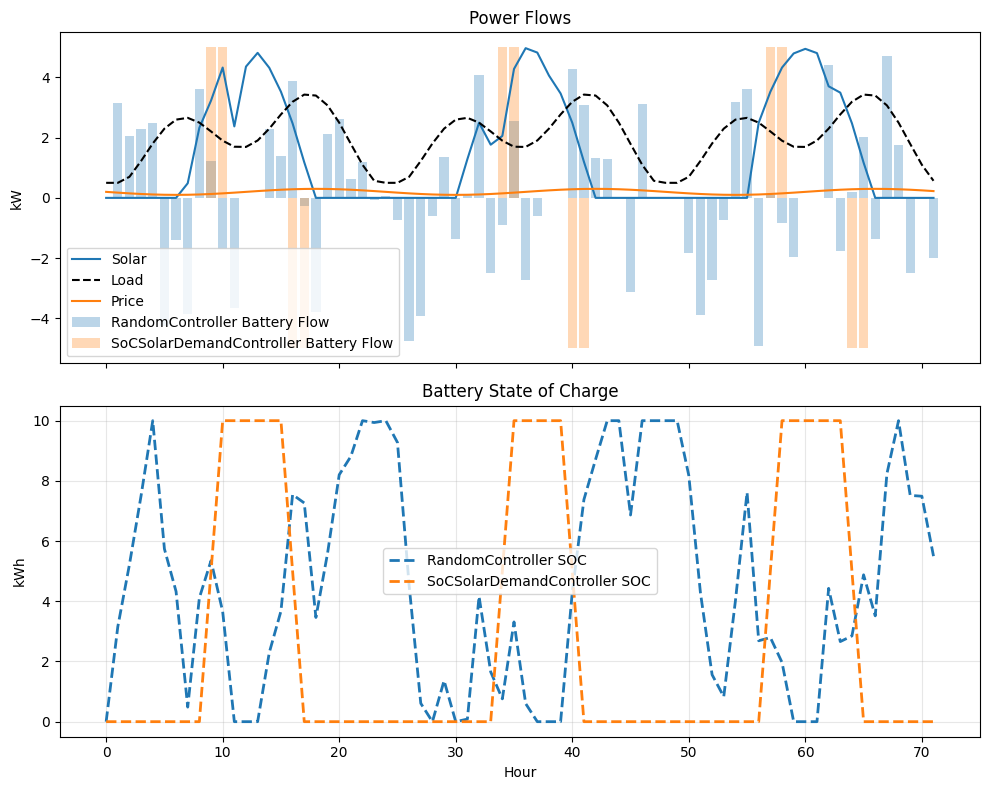

In [216]:
controllers = {
    # "RuleBasedController": RuleBasedController,
    # "CostOptimizedRuleBasedController": CostOptimizedRuleBasedController,
    # "SOCAwareRuleBasedController": SOCAwareRuleBasedController,
    # "PVOptimalController": PVOptimalController,
    "RandomController": RandomController,
    "SoCSolarDemandController": SoCSolarDemandController
}

all_results = {}
for name, controller in controllers.items():
    all_results[name] = run_experiment(controller)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
df = list(all_results.values())[0]
ax1.plot(df['solar'], label='Solar')
ax1.plot(df['load'], 'k--', label='Load')
ax1.plot(df['price'], label='Price')
for name, df in all_results.items():
   # total_cost = df['cost'].sum()
    #print(f"Total Cost for {name}: €{total_cost:.2f}")


    # Ax1: Physics
    ax1.set_title("Power Flows")


    ax1.bar(df.index, df['battery_action_actual'], alpha=0.3, label=f'{name} Battery Flow')
    ax1.legend()
    ax1.set_ylabel("kW")

    # Ax2: Battery State
    ax2.set_title("Battery State of Charge")
    ax2.plot(df['soc'], '--', linewidth=2, label=f"{name} SOC")
    ax2.set_ylabel("kWh")
    ax2.set_xlabel("Hour")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
plt.show()